# 21M.387 Fundamentals of Music Processing

## Structure Analysis

In this lecture: analyzing a piece of music to find its underlying structure - areas of similarities, areas of differences, and the boundaries that separate them. We will look at two different (but related) techniques.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import sys
sys.path.append("..")
import fmplib as fmp

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['image.interpolation'] = 'nearest'
fmp.documentation_button()

## Reading

Chapter 4.0 – 4.2 (pp 167 - 194), 4.4 (pp 207 – 215)

<img src="images/book_cover.png" width=200>

## Goal 
- To divide audio recording into temporal segments corresponding to musical parts.
- To somehow associate or group these parts into categories

## Musical Structures

### Rock/Pop Example

<img src="images/pop_song_form.png" width=400>

### Sonata Form

<img src="images/sonata_form.png" width=400>

### Rondo

<img src="images/rondo_form.png" width=400>


## Principles of Segmentation

- Novelty
- Homogeneity
- Repetition

<img src="images/image_proc_examples.png" width=700>

Note that novelty and homogeneity are "two sides of the same coin"

Musical structure can sometimes be ill-defined. Analysis of musical form can be somewhat subjective.

## Example: Brahms Hungarian Dance #5

In [2]:
snd = fmp.load_wav("audio/brahms_hungarian_dance_5a.wav")
fs = 22050.
ipd.Audio(snd, rate = fs)

In [3]:
@interact(segs=False)
def show_png(segs):
    global img_name
    img_name = "images/brahms_hungarian5_score%s.png" % ('', '2')[segs]
    return ipd.Image(img_name)

interactive(children=(Checkbox(value=False, description='segs'), Output()), _dom_classes=('widget-interact',))

The form is:
<img src="images/brahms_h5_form.png" width=600>


Notes:
- __A2__ is an octave higher than __A1__
- __A__ and __B__ are in G minor
- __C__ is in G major
- Note how Repetition, Novelty and Homogeneity appear in this piece.
- Note also how this segmentation is somewhat arbitrary.

## Feature Representation

Possible feature choices:
- Timbre / Instrumentation: Mel Frequency Cepstral Coefficients (MFCC)
- Tempo / Rhythm: Tempograms
- Pitch / Harmonic: Chromagrams

We will, of course, choose chroma features.

Below is the chromagram for the Brahms _Hungarian Dance #5_.

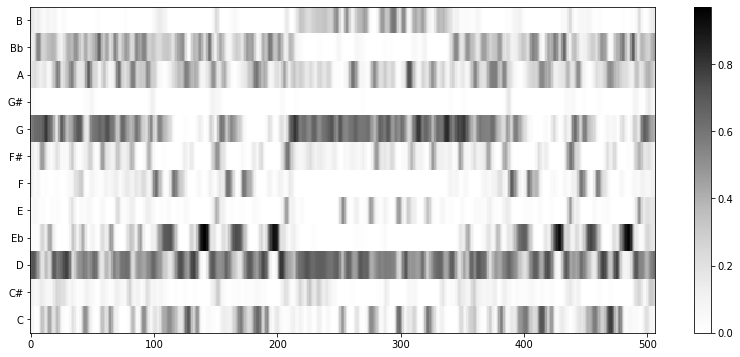

In [4]:
fft_len = 4096
hop_size = fft_len // 2
cens_filt_len1 = 25
cens_ds1 = 3
chroma1 = fmp.make_chromagram(snd, fs, fft_len, hop_size, tuning=0.2)
chroma1 = fmp.cens(chroma1, cens_filt_len1, cens_ds1)

plt.imshow(chroma1, origin='lower', aspect='auto', cmap='Greys')
fmp.chord_template_labels(axis=0)
plt.colorbar();

- Note the predominant energies in $\mathbf{G}$ and $\mathbf{D}$.
- Note the energies in $\mathbf{B \flat}$ and $\mathbf{B \natural}$.

## Self Similarity Matrix (SSM)

Overall idea: Compare each element in the feature sequence $x$ to every other element $x$.
- Similar to cost matrix used in music alignment.
- But, this comparison yields a __score__ value: _Higher_ means _more similar_.
- Compare with dot product:
$$s(a,b) = \langle a, b \rangle$$

- $\mathbf{S}$, the SSM, is $N \times N$
$$ \mathbf{S}[n,m] = s(x_n,x_m) $$


In our case, $s \in [0,1]$ because:
- chroma vectors are all non-negative.
- assume chroma vectors are all normalized (length 1).

Here is the SSM for the above example:

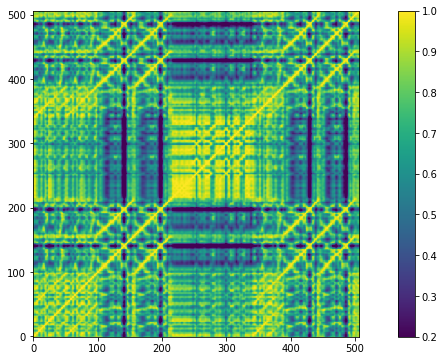

In [5]:
ssm1 = fmp.make_ssm(chroma1)
plt.figure()
plt.imshow(ssm1, origin='lower', vmin=0.2)
plt.colorbar()
plt.show()

Some observations:
- Symmetric along diagonal
- The diagonal itself is always 1.

Interesting landmarks on the SSM are:
- Paths: repetition
- Blocks: homogeneity
- Corners: novelty

### Paths

In [6]:
paths = []
paths.append(((0,0), (500,500)))
paths.append(((50, 0), (100, 50)))
paths.append(((340,0), (390, 50)))
paths.append(((160,100), (210, 150)))
paths.append(((340,50), (500, 210)))
paths.append(((450,105), (500, 155)))
paths.append(((390,157), (440, 207)))
paths.append(((295,245), (335, 285)))
paths.append(((450,392), (500, 442)))


@interact(show=False)
def doit(show):
    plt.imshow(ssm1, origin='lower', cmap='Greys', vmin=0.2);
    plt.colorbar();
    if show:
        fmp.plot_ssm_paths(ssm1.shape[0], paths)
    plt.show()

interactive(children=(Checkbox(value=False, description='show'), Output()), _dom_classes=('widget-interact',))

<font color='red'>__Whiteboard__</font>: Paths

### Blocks

In [7]:
blocks = [ (0, 0, 100, 100) , (100, 100, 205, 205), (205, 205, 345, 345), 
          (345,345,390,390), (390,390,500,500) ]
@interact(show=False)
def doit(show):
    plt.imshow(ssm1, origin='lower', cmap='Greys', vmin=0.2);
    plt.colorbar();
    if show:
        fmp.plot_ssm_blocks(ssm1.shape[0], blocks)
    plt.show()        

interactive(children=(Checkbox(value=False, description='show'), Output()), _dom_classes=('widget-interact',))

<font color='red'>__Whiteboard__</font>: Blocks

### Corners

In [8]:
corners = [ (100, 100) , (205, 205), (390, 390) ]
@interact(show=False)
def doit(show):
    plt.imshow(ssm1, origin='lower', cmap='Greys', vmin=0.2);
    plt.colorbar();
    if show:
        fmp.plot_ssm_corners(ssm1.shape[0], corners)
    plt.show()                

interactive(children=(Checkbox(value=False, description='show'), Output()), _dom_classes=('widget-interact',))

## Block Enhancements

How much filtering / downsampling to apply?

In [9]:
@interact(idx=(0,4), ssm=False)
def test_cens_params(idx=0, ssm=False):
    ds =  (1, 5,  10,  20, 40)[idx]
    win = (1, 20, 40, 100, 200)[idx]
    
    chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, tuning = 0.2)
    chroma = fmp.cens(chroma, win, ds)
    
    if not ssm:
        plt.figure(figsize=(10,3))
        plt.imshow(chroma, origin='lower', aspect='auto', cmap='Greys');
    else:
        ssm = fmp.make_ssm(chroma)
        plt.figure(figsize=(10,6))
        plt.imshow(ssm, origin='lower', cmap='Greys');
    txt = 'w_len=%d\nds=%d' % (win, ds)
    plt.text(1.25, .9, txt, fontsize=15, transform=plt.gca().axes.transAxes)
    plt.colorbar()
    plt.show()        

interactive(children=(IntSlider(value=0, description='idx', max=4), Checkbox(value=False, description='ssm'), …

## Segmentation by "Corner Detection"

- Goal: find locations where musical homogeneity changes
- Idea: look for "corners" along the diagonal.
- Think of a checkerboard

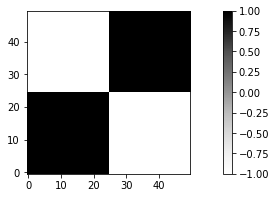

In [10]:
cb_len = 50
cb = fmp.make_checkerboard(cb_len, False, False)
plt.figure(figsize = (12,3))
plt.imshow(cb, origin='lower', cmap='Greys');
plt.colorbar();

- This is $\mathbf{K}_B$, a binary _checkerboard kernel_ of size $M \times M$, where $M = 2L$.
- Slide $\mathbf{K}_B$ along the diagonal of $\mathbf{S}$.
- Sum the element-wise products of $\mathbf{K}_B$ (centered at $[n,n]$) and $\mathbf{S}$. 
- This produces a __checkboard novelty function__: $\Delta_K[n]$:

$$\Delta_K[n] =  \sum_{k,l \in [-L:L-1]} \mathbf{K}_B[k, l] \mathbf{S}[n+k, n+l] $$

In [11]:
cens_filt_len2 = 40
cens_ds2 = 5
chroma2 = fmp.make_chromagram(snd, fs, fft_len, hop_size, tuning = 0.2)
chroma2 = fmp.cens(chroma2, cens_filt_len2, cens_ds2)
ssm2 = fmp.make_ssm(chroma2)

@interact(loc=(0,250,20))
def checker_test(loc=0):
    plt.imshow(ssm2, origin='lower', cmap='PuBu');
    plt.colorbar();
    
    overlay = np.ma.masked_where(True, ssm2)
    n = loc
    h,w = cb.shape
    overlay[n:n+h , n:n+w] = cb

    plt.imshow(overlay, origin='lower', cmap='Greys')
    plt.show()

interactive(children=(IntSlider(value=0, description='loc', max=250, step=20), Output()), _dom_classes=('widge…

<font color='red'>__Whiteboard__</font>: Checkerboard Kernel

Apply 2D Gaussian $\mathbf{G}$ to create a tapered checkerboard kernel $\mathbf{K}_{G} = \mathbf{G} \odot \mathbf{K}_B$ ($\odot$ means element-wise multiplication).

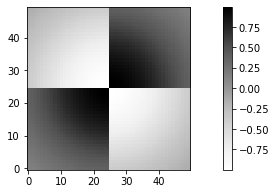

In [12]:
cb = fmp.make_checkerboard(cb_len, True, False)
plt.figure(figsize = (12,3))
plt.imshow(cb, origin='lower', cmap='Greys');
plt.colorbar();

In [13]:
nov_test = fmp.diagonal_novelty(ssm2, cb_len)

@interact(loc=(0, 250, 20))
def checker_test(loc=0):
    plt.figure(figsize=(10,6))
    plt.gcf().add_axes((-.35,.25,1,.75))
    plt.imshow(ssm2, origin='lower', cmap='PuBu');
    plt.colorbar();
    
    overlay = np.ma.masked_where(True, ssm2)
    n = loc
    h,w = cb.shape
    overlay[n:n+h , n:n+w] = cb
    plt.imshow(overlay, origin='lower', cmap='Greys');

    plt.gcf().add_axes((0,0,.45,.2))
    
    win = np.ones(ssm2.shape[0])
    win[loc+cb_len:] = 0
    plt.plot(nov_test * win)
    plt.xlim(0, len(nov_test))
    plt.show()

interactive(children=(IntSlider(value=0, description='loc', max=250, step=20), Output()), _dom_classes=('widge…

### Effect of Kernel Size

In [14]:
@interact(cb_len=(10, 100, 10)) 
def checker_test(cb_len=5):
    nov = fmp.diagonal_novelty(ssm2, cb_len)    
    cb = fmp.make_checkerboard(cb_len, True, True)

    plt.figure(figsize=(10,6))
    plt.gcf().add_axes((-.35,.25,1,.75))
    plt.imshow(ssm2, origin='lower', cmap='PuBu')
    plt.colorbar()
    
    overlay = np.ma.masked_where(True, ssm2)
    n = 125 - cb_len//2
    h,w = cb.shape
    overlay[n:n+h , n:n+w] = cb
    plt.imshow(overlay, origin='lower', cmap='Greys')
    
    ff = fs / hop_size / cens_ds2
    txt = f"Kernel len\n = {cb_len} pixels\n = {cb_len / ff:.2f} seconds"
    plt.text(ssm2.shape[1] * 1.25, 0, txt, fontsize=15)

    plt.gcf().add_axes((0,0,.45,.2))
    plt.plot(nov)
    plt.xlim(0, len(nov))
    plt.show()
    

interactive(children=(IntSlider(value=10, description='cb_len', min=10, step=10), Output()), _dom_classes=('wi…

### Final step: pick peaks

- Peaks in the novelty curve $\Delta_K[n]$  $\rightarrow$ likely segment boundaries
- As always, peak picking can be tricky.
- Use a variant: find the maximum value within a neighborhood of length $L$.

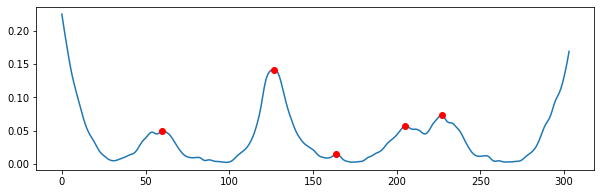

In [15]:
cb_len = 70
nov2 = fmp.diagonal_novelty(ssm2, cb_len)
peaks = fmp.find_region_peaks(nov2, int(8 * fs/hop_size/cens_ds2)) # use a neighborhood of 8 seconds
plt.figure(figsize=(10,3))
plt.plot(nov2)
plt.plot(peaks, nov2[peaks], 'ro');

### Comparing to Ground Truth

- Load annotations (ground truth) of Brahms _Hungarian Dance #5_
- Show annotations
- Play with two variables:
  - Chroma filtering and downsampling
  - Checkerboard kernel size

In [16]:
ref = fmp.load_boundary_annotations("audio/brahms_hungarian_dance_5a.lab")

@interact(cb_sec=(4, 40, 4), wi = (0, 3))
def checker_test(cb_sec=5, wi=0):
    cens_filt_len = (15, 40, 100, 150)[wi]
    cens_ds = int(cens_filt_len / 10)
    ff = fs / hop_size / cens_ds
    chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, normalize=False, tuning=0.2)
    chroma = fmp.cens(chroma, cens_filt_len, cens_ds)
    ssm = fmp.make_ssm(chroma)

    ff = fs / hop_size / cens_ds
    ref_fr = ref * ff

    cb_len = int(round(ff * cb_sec)) // 2 * 2 # make kernel even-length
    nov = fmp.diagonal_novelty(ssm, cb_len)
    cb = fmp.make_checkerboard(cb_len)

    plt.figure(figsize=(10,6))
    plt.gcf().add_axes((-.35,.25,1,.75))
    plt.imshow(ssm, origin='lower', cmap='PuBu');
    plt.colorbar();

    overlay = np.ma.masked_where(True, ssm)
    n = int(ssm.shape[0]*.3 - cb_len/2)
    h,w = cb.shape
    overlay[n:n+h , n:n+w] = cb
    plt.imshow(overlay, origin='lower', cmap='Greys');
    
    plt.vlines(ref_fr, 0, ssm.shape[0], 'y', linewidth=2)

    txt = f"Chroma:\n filt = {cens_filt_len}\n ds = {cens_ds}\n ff = {cens_ds:.2f}\n\n"
    txt += f"Kernel\n = {cb_len} pixels\n = {cb_len / ff:.2f} seconds"
    plt.text(ssm.shape[1] * 1.25, 0, txt, fontsize=15)

    peaks = fmp.find_region_peaks(nov, int(6*ff))

    plt.gcf().add_axes((0.02,0,.43,.2))
    plt.plot(nov)
    plt.plot(peaks, nov[peaks], 'ro')
    plt.vlines(ref_fr, 0, np.max(nov), 'y', linewidth=2)
    plt.xlim(0, len(nov))
    plt.show()
    

interactive(children=(IntSlider(value=5, description='cb_sec', max=40, min=4, step=4), IntSlider(value=0, desc…

### Observations
- Kernel Novelty is good for homogeneity / novelty
- Finds major _harmonic differences_, but these don't necessarily lie on boundaries
- Not good for identifying repetition


## Segmentation by Repetition

- Goal: find locations where music repeats
- Idea: look at paths parallel to main diagonal

In [17]:
paths = []
paths.append(((0,0), (500,500)))
paths.append(((50, 0), (100, 50)))
paths.append(((340,0), (390, 50)))
paths.append(((160,100), (210, 150)))
paths.append(((340,50), (500, 210)))
paths.append(((450,105), (500, 155)))
paths.append(((390,157), (440, 207)))
paths.append(((295,245), (335, 285)))
paths.append(((450,392), (500, 442)))


@interact(show=False)
def doit(show):
    plt.imshow(ssm1, origin='lower', cmap='Greys', vmin=0.2);
    plt.colorbar();
    if show:
        fmp.plot_ssm_paths(ssm1.shape[0], paths)
    plt.show()

interactive(children=(Checkbox(value=False, description='show'), Output()), _dom_classes=('widget-interact',))

### Path Enhancements

Enhance paths by filtering along the diagonal:

 $$\mathbf{S}_D[n,m] = {1 \over L} \sum_{l=-(L-1)/2}^{(L-1)/2} \mathbf{S}[n+l, m+l]$$

for odd values of $L$.

This helps:
- fix path imperfections
- increase path contrast



In [18]:
@interact(wlen=(1, 45, 4))
def test_diag(wlen=0):
    ssm_s = fmp.diagonal_smoothing(ssm1, wlen)
    plt.imshow(ssm_s, origin='lower', vmin=0.2)
    plt.colorbar()
    plt.show()


interactive(children=(IntSlider(value=1, description='wlen', max=45, min=1, step=4), Output()), _dom_classes=(…

### Thresholding

Improve algorithms performance by removing noise / small variations.

For each value in $\mathbf{S}[n,m]$, keep values $\mathbf{S}[n,m] \ge \tau$, with $\tau \in [0,1]$, and set all others to $0$. 

This results in only having values in the range $[\tau, 1]$.



In [19]:
@interact(tau=(0.25, 1, 0.05))
def test_diag(tau=0):
    ssm_s = fmp.diagonal_smoothing(ssm1, 25)
    ssm_t = ssm_s.copy()
    ssm_t[ssm_t < tau] = 0
    plt.imshow(ssm_t, origin='lower', cmap='Greys')
    plt.colorbar()
    plt.show()
    

interactive(children=(FloatSlider(value=0.25, description='tau', max=1.0, min=0.25, step=0.05), Output()), _do…

### Thresholding and Scaling

As a further enhancement, expand desired values to the full dynamic range.

After thresholding with $\tau$, linearly scale all values in the range $[\tau, 1]$ to the range $[0, 1]$ to produce $\mathbf{S}_\tau$.

In [20]:
@interact(tau=(0.05, .95, 0.05))
def test_diag(tau=0):
    ssm_s = fmp.diagonal_smoothing(ssm1, 25)
    ssm_t = fmp.thresh_and_scale(ssm_s, tau)
    plt.imshow(ssm_t, origin='lower', cmap='Greys')
    plt.colorbar()
    plt.show()

interactive(children=(FloatSlider(value=0.05, description='tau', max=0.95, min=0.05, step=0.05), Output()), _d…

### Structure Features

- Idea: find locations where structural changes occur:
  - local: blocks
  - global: repetitions
  
Create a __time-lag matrix__ from $\mathbf{S}$ (or enhanced $\mathbf{S}$):

- Begin with $\mathbf{S}$. Matrix coordinates are (time, time).
<img src="images/time_lag1.png" width=200>


- Apply Matrix Shearing:
$$\mathbf{L}[l,n] = \mathbf{S}[n+l, n]$$
- Matrix coordinates are (lag, time).
<img src="images/time_lag2.png" width=200>


- Arrange the triangles back into a square using _modulo_ to create the __circular time lag__ matrix.
$$\mathbf{L^{\circ}}[l,n] = \mathbf{S}[(n+l) \text{ mod } N, n]$$
- Matrix coordinates are (modulo lag, time)
<img src="images/time_lag3.png" width=200>

What does this lag matrix mean?
- large values $\rightarrow$ similar musical material
- comparing columns: horizontal stripes $\rightarrow$ similar music separated by a constant time offset (lag).


<font color='red'>__Whiteboard__</font>: Lag Matrix

Back to our path enhanced SSM:

In [21]:
tau = .85
diag_len = 15
ssm3 = fmp.diagonal_smoothing(ssm1, diag_len)
ssm3 = fmp.thresh_and_scale(ssm3, tau)

@interact(lag=False)
def test_lag_ssm(lag):
    s = fmp.make_lag_matrix(ssm3) if lag else ssm3
    plt.imshow(s, origin='lower', cmap='Greys')
    plt.colorbar()
    plt.show()


interactive(children=(Checkbox(value=False, description='lag'), Output()), _dom_classes=('widget-interact',))

### Derivative Kernel

- Act as a horizontal derivative (differentiator across time)
- Finds large deltas at the mid-point
- Built-in smoothing via Gaussian falloff (like checkerboard)

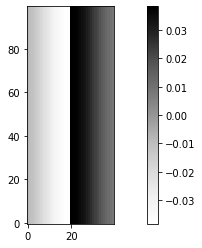

In [22]:
ck_len = 40
ck = fmp.make_derivative_kernel(100, ck_len)
plt.figure(figsize = (12,4))
plt.imshow(ck, origin='lower', cmap='Greys');
plt.colorbar();

This is $\mathbf{K}_{\Delta}$, a _derivative kernel_. To use it:
- Slide $\mathbf{K}_{\Delta}$ horizontally along $\mathbf{L^{\circ}}$. At each time step $n$:
    - Compute $\mathbf{D}^{[n]} = \mathbf{K}_{\Delta}^{[n]} \odot \mathbf{L^{\circ}}$, where $\mathbf{K}_{\Delta}^{[n]}$ is the kernel centered at $n$.
    - Sum the rows to produce a column vector $l_{\Delta}^{[n]} = \sum_j \mathbf{D}^{[n]}[m,j]$ 
    - The magnitude ($L_2$ norm) of $l_{\Delta}^{[n]}$ represents the likelihood of a structural boundary at $n$.

- $\Delta_S[n] = \Vert l_{\Delta}^{[n]} \Vert$ is the __structure novelty function__.

In [23]:
ck_len = 80
lag_ssm = fmp.make_lag_matrix(ssm3)
ck = fmp.make_derivative_kernel(lag_ssm.shape[0], ck_len)
nov = fmp.column_derivative(lag_ssm, ck_len)

@interact(loc=(0, 500 - ck_len, 10), show_ref=False)
def column_test(loc=0, show_ref=False):
    plt.figure(figsize=(10,6))
    plt.gcf().add_axes((-.35,.25,1,.75))
    plt.imshow(lag_ssm, origin='lower', cmap='PuBu');
    plt.colorbar();
    
    overlay = np.ma.masked_where(True, lag_ssm)
    n = loc
    h,w = ck.shape
    overlay[:, n:n+w] = ck
    plt.imshow(overlay, origin='lower', cmap='Greys');

    plt.gcf().add_axes((-.02,0,.49,.2))
    
    win = np.ones(lag_ssm.shape[0])
    win[loc+ck_len:] = 0
    plt.plot(nov * win)
    plt.ylim(0, np.max(nov))

    if show_ref:
        ff = fs / hop_size / cens_ds1
        ref_fr = ref * ff
        plt.vlines(ref_fr, 0, np.max(nov), 'y')
    plt.show()


interactive(children=(IntSlider(value=0, description='loc', max=420, step=10), Checkbox(value=False, descripti…

### Pick Peaks
- As before.

In [24]:
@interact(dk_len=(10, 200, 10))
def column_test(dk_len=0):
    plt.figure(figsize=(10,6))
    plt.gcf().add_axes((-.35,.25,1,.75))
    plt.imshow(lag_ssm, origin='lower', cmap='PuBu');
    plt.colorbar();
    
    dk = fmp.make_derivative_kernel(lag_ssm.shape[0], dk_len)

    overlay = np.ma.masked_where(True, lag_ssm)
    n = int(lag_ssm.shape[1]//2) - dk_len//2
    h,w = dk.shape
    overlay[:, n:n+w] = dk
    plt.imshow(overlay, origin='lower', cmap='Greys');

    nov = fmp.column_derivative(lag_ssm, dk_len)
    ff = fs / hop_size / cens_ds1
    peaks = fmp.find_region_peaks(nov, int(6 * ff))
    ref_fr = ref * ff
    
    plt.gcf().add_axes((-.02,0,.49,.2))
    plt.plot(nov)
    plt.plot(peaks, nov[peaks], 'ro')
    plt.vlines(ref_fr, 0, np.max(nov), 'y')
    plt.show()


interactive(children=(IntSlider(value=10, description='dk_len', max=200, min=10, step=10), Output()), _dom_cla…

Observations:
- Finds locations at repetition boundaries
- Places where paths start and end
- Also captures some effects of novelty (from blocks)

## Evaluation

- Ground truth (or _reference annotations_) for segmentation contains two types of information
  - Boundaries
  - Labels

- We will have a closer look at boundaries.

### Annotation Ambiguity

There is no "one correct annotation" for segmentation. For example, in the Hungarian Dance:

<img src="images/brahms_multi_annotations.png" width=400>

### Precision, Recall, F-measure

A commonly used evaluation criteria for classification / estimation algorithms.

Estimation results are compared to Reference annotations. There are four possible results:
- True Positive
- True Negative
- False Positive
- False Negative

In binary classification, all four results may apply:

|Estimate |Reference |Result|
|-|-|-|
|Pos|Pos|True Positive|
|Neg|Neg|True Negative|
|Pos|Neg|False Positive|
|Neg|Pos|False Negative|


In boundary evaluation, we compare two boundary annotations - sequences of time values:
$$B^{\text{Est}} = (b_1, b_2, \dots, b_j)$$
$$B^{\text{Ref}} = (b_1, b_2, \dots, b_k)$$

where each $b$ is a value in seconds.

To compare a particular $b_j^{\text{Est}}$ with a $b_k^{\text{Ref}}$:
- a "match" is when $\vert b^{\text{Est}} - b^{\text{Ref}} \vert < \tau$
- all matches count towards _True Positive_ (#TP)
- all remaining $b^{\text{Est}}$ count towards _False Positive_ (#FP)
- all remaining $b^{\text{Ref}}$ count towards _False Negative_ (#FN)
- _True Negative_ is not a meaningful category

Precision is:
$$P = {\text{#TP} \over \text{#TP} + \text{#FP}} $$

Recall is:
$$R = {\text{#TP} \over \text{#TP} + \text{#FN}} $$

F-measure combines the two:
$$F =  {2 \cdot P \cdot R \over  P + R }  $$

<font color='red'>__Whiteboard__</font>: F-Measure


Example:

In [25]:
# helper function for seeing results
def plot_est_ref(nov, est_fr, ref_fr, ff): 
    est_tp, est_fp, ref_tp, ref_fn = fmp.pos_neg_split(est_fr, ref_fr, 3. * ff)
    P, R, F = fmp.calc_prf(est_fr, ref_fr, 3. * ff)
    
    txt =  f"P = {P:.2f}\n"
    txt += f"R = {R:.2f}\n"
    txt += f"F = {F:.2f}\n"
    
    plt.figure(figsize=(12,3))
    plt.plot(nov)
    plt.plot(est_tp, nov[est_tp], 'go')
    plt.plot(est_fp, nov[est_fp], 'ro')
    plt.vlines(ref_tp, 0, np.max(nov), 'g', linewidth=2)
    plt.vlines(ref_fn, 0, np.max(nov), 'y', linewidth=2)
    plt.xlim(0, len(nov))
    plt.text(.8, 1, txt, fontsize=15, transform=plt.gca().axes.transAxes)


Using checkerboard novelty method:

In [26]:
@interact(cb_len=(8, 80, 8))
def checker_test(cb_len=4):
    nov = fmp.diagonal_novelty(ssm2, cb_len)
    ff = fs / hop_size / cens_ds2
    est = fmp.find_region_peaks(nov, int(8 * ff))
    plot_est_ref(nov, est, ref * ff, ff)
    plt.show()
    

interactive(children=(IntSlider(value=8, description='cb_len', max=80, min=8, step=8), Output()), _dom_classes…

Use structure features method:

In [27]:
@interact(ck_len=(10, 240, 10))
def bounds_test(ck_len=4):
    nov = fmp.column_derivative(lag_ssm, ck_len)
    ff = fs / hop_size / cens_ds1
    est = fmp.find_region_peaks(nov, int(8 * ff))
    plot_est_ref(nov, est, ref * ff, ff)
    plt.show()

interactive(children=(IntSlider(value=10, description='ck_len', max=240, min=10, step=10), Output()), _dom_cla…

## Preparation for Lab 7

In Lab 7, you will analyze your own song for section boundaries and compare that analysis to your own ground-truth annotations. Please be prepared by finding, downloading, or otherwise acquiring a short song or piece, ideally 3-5 minutes in length. It should be music that you know well so that you can easily recognize its section boundaries. Convert that file to a mono 22k WAV file using Audacity.

Also install [Sonic Visualizer](https://www.sonicvisualiser.org/).
